## S1

In [1]:
import pandas as pd
import seaborn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 加载数据
penguins = seaborn.load_dataset("penguins")

# 数据预处理
print("Q2.1.1 Data Preprocessing:")

# 原始数据点数量
print(f"Number of data points in the whole dataset originally: {len(penguins)}")

# 删除含有 NaN 的行
penguins_cleaned = penguins.dropna().copy()  # 显式创建副本以避免系统警告
print(f"Number of data points in the whole dataset after deleting incomplete data: {len(penguins_cleaned)}")

# 将字符串特征转换为数值
label_encoders = {}
for col in ['species', 'island', 'sex']:
    le = LabelEncoder()
    penguins_cleaned.loc[:, col] = le.fit_transform(penguins_cleaned[col])  # 使用 .loc 操作列
    label_encoders[col] = le

penguins_cleaned['species'] = penguins_cleaned['species'].astype(int)
penguins_cleaned['island'] = penguins_cleaned['island'].astype(int)
penguins_cleaned['sex'] = penguins_cleaned['sex'].astype(int)


# 划分训练集和测试集
X = penguins_cleaned.drop(columns=['species'])  # 特征
y = penguins_cleaned['species']  # 目标变量
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  # 根据官方文件选择42随机

# 输出数据分割信息
print(f"Number of data points in the training set after splitting: {len(X_train)}")
print(f"Number of data points in the test set after splitting: {len(X_test)}")


Q2.1.1 Data Preprocessing:
Number of data points in the whole dataset originally: 344
Number of data points in the whole dataset after deleting incomplete data: 333
Number of data points in the training set after splitting: 233
Number of data points in the test set after splitting: 100


## S2

Q2.1.2 Data Statistics:


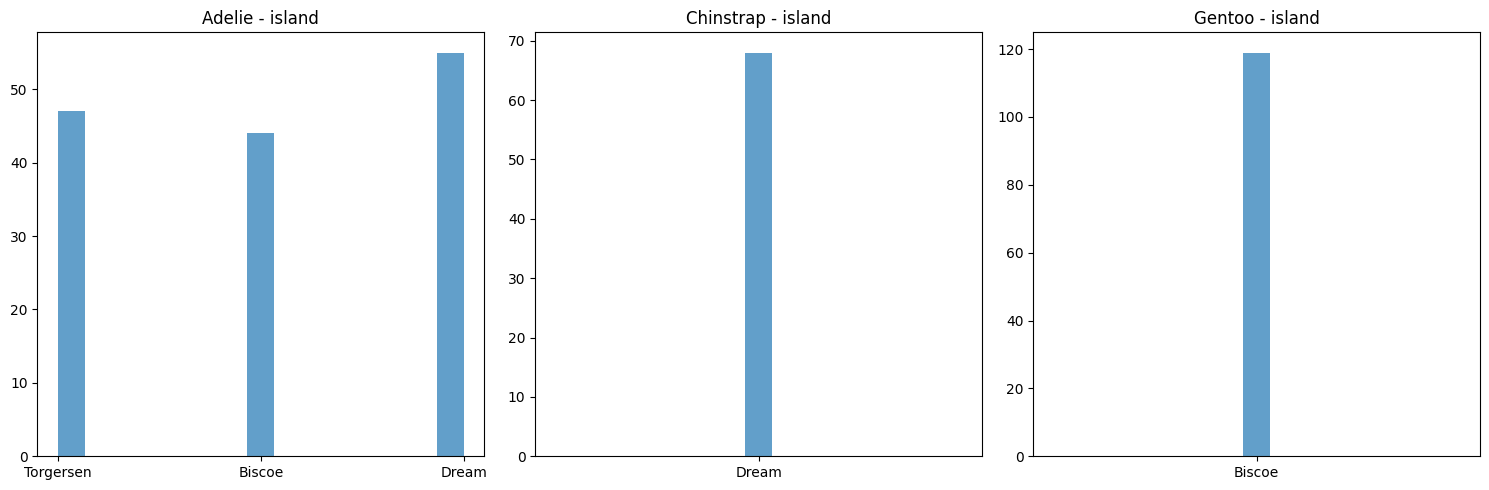

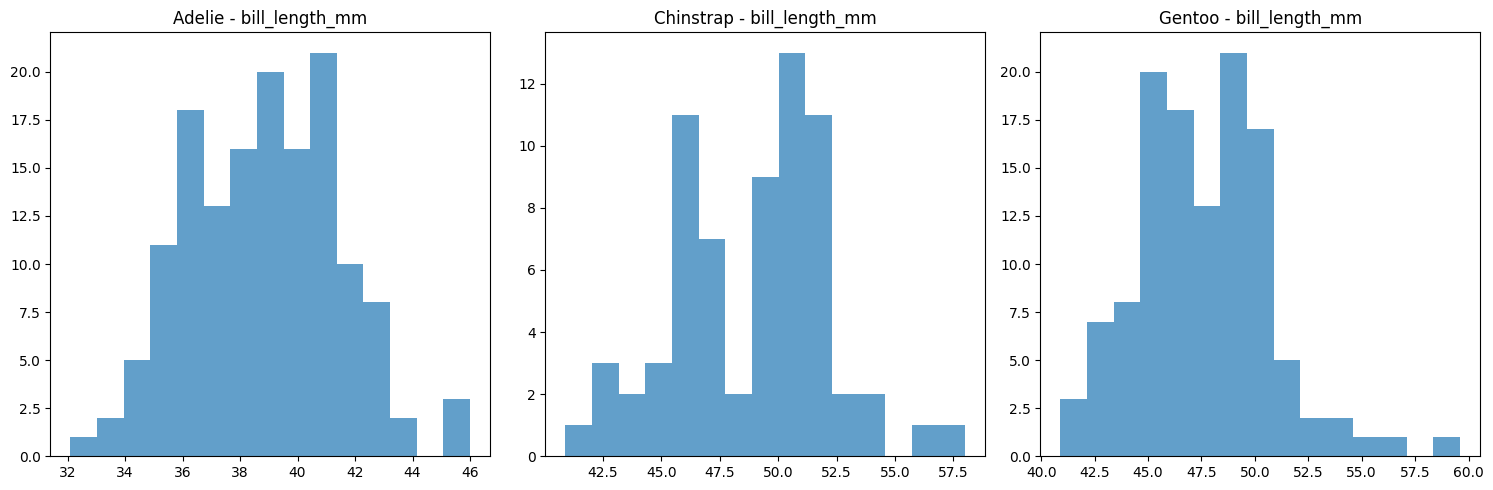

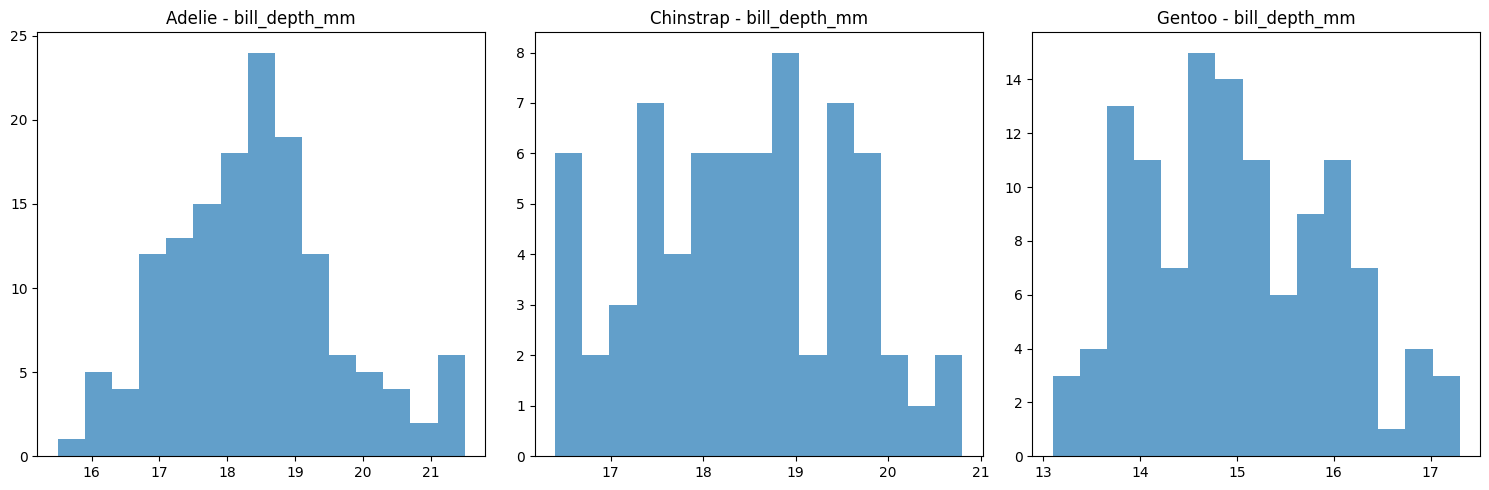

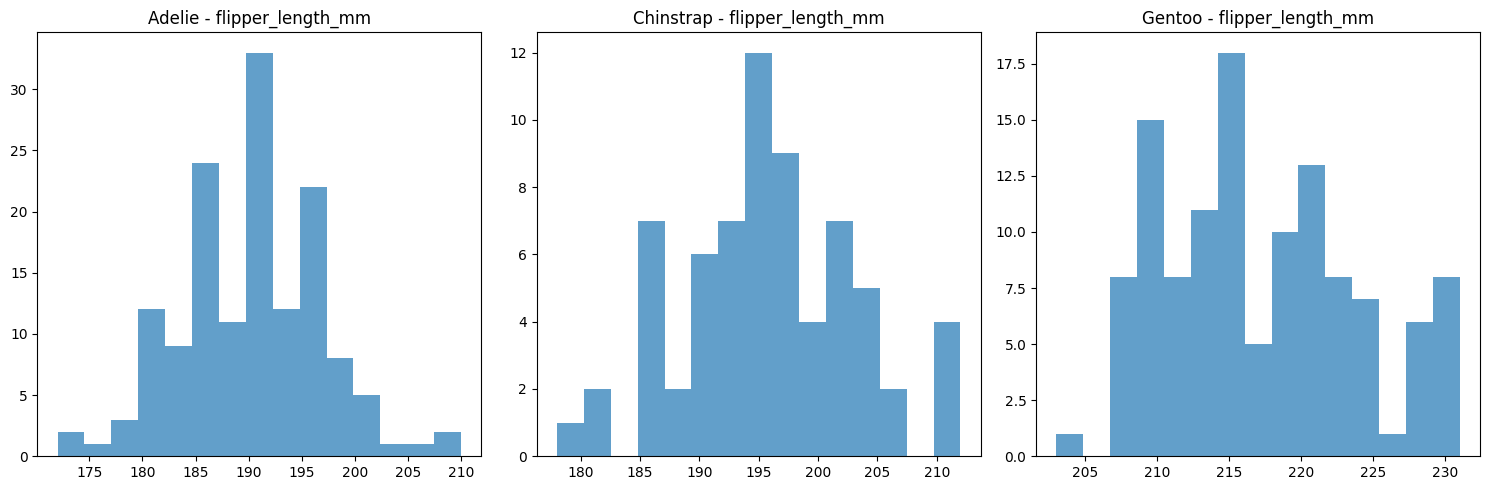

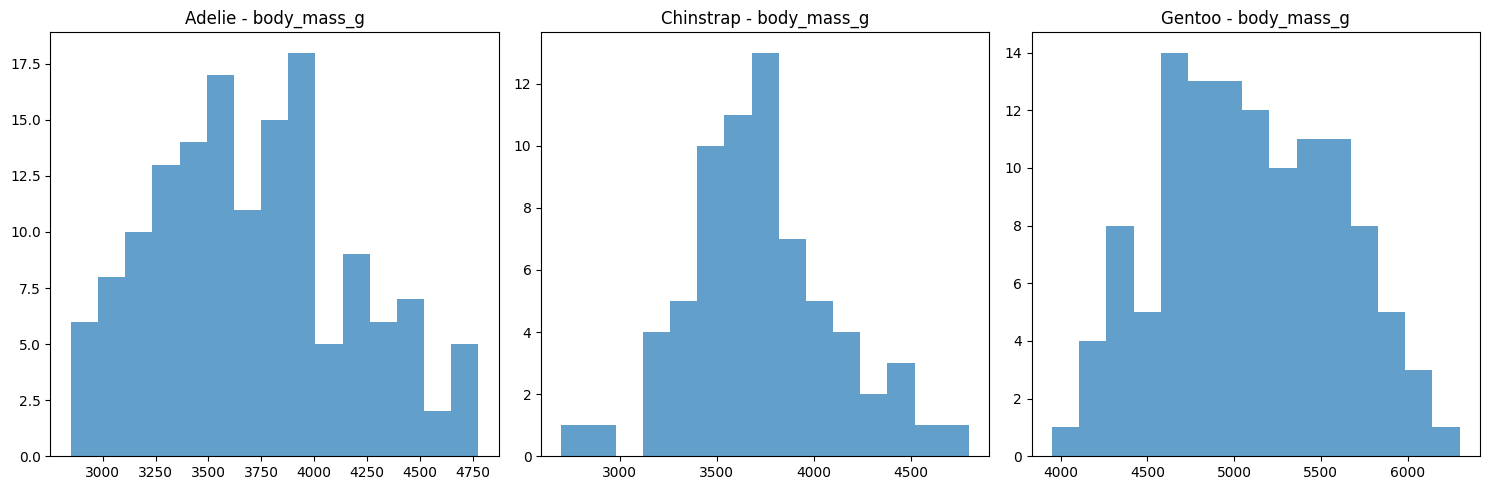

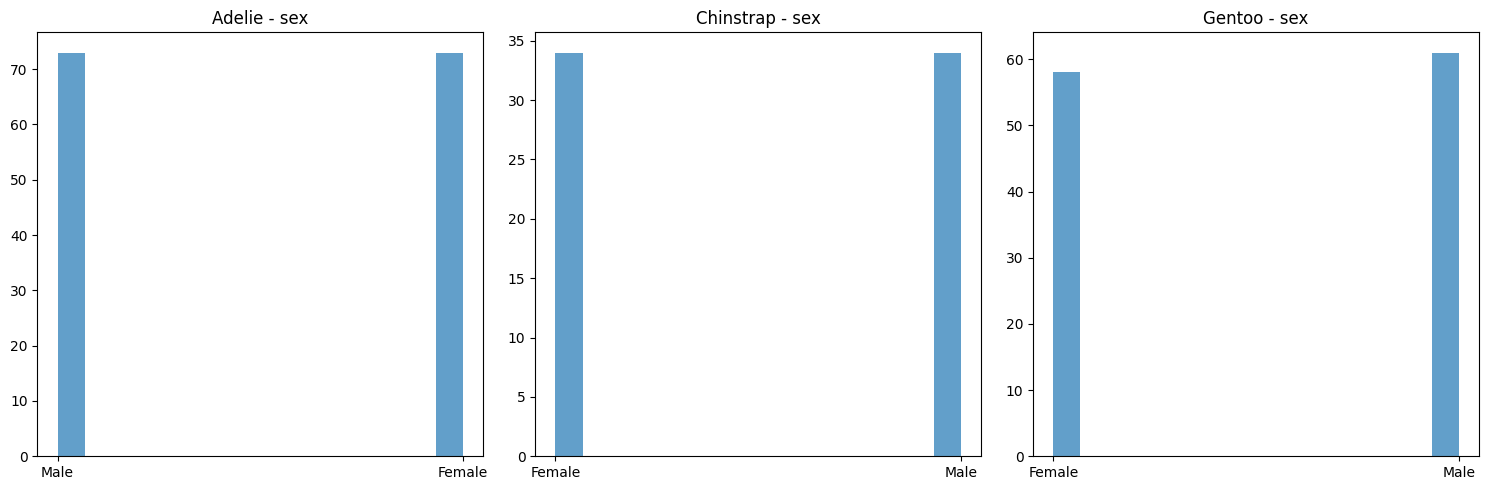

In [2]:
import matplotlib.pyplot as plt

print("Q2.1.2 Data Statistics:")

# 将 `species` 唯一值转换为整数列表以兼容 `LabelEncoder`
species_encoded_values = penguins_cleaned["species"].unique().astype(int)

# 映射每个类别为原始名称
species_names = label_encoders["species"].inverse_transform(species_encoded_values)

# 特征列
features = X.columns

# 绘制每个特征的直方图
for i, feature in enumerate(features):
    plt.figure(figsize=(15, 5))
    
    # 遍历每种企鹅类别
    for j, species_encoded in enumerate(species_encoded_values):
        # 筛选对应类别的数据
        data = penguins_cleaned[penguins_cleaned["species"] == species_encoded].copy()
        
        # 如果是岛屿或性别，映射回文字
        if feature in ["island", "sex"]:
            # 确保输入是int类 (debug出来的，不知道为什么没有这一步会报错)
            data[feature] = label_encoders[feature].inverse_transform(data[feature].astype(int))
        
        # 映射类别名称
        species_name = label_encoders["species"].inverse_transform([species_encoded])[0]
        
        plt.subplot(1, 3, j + 1)
        plt.hist(data[feature], bins=15, alpha=0.7)
        plt.title(f"{species_name} - {feature}")
    
    # 调整布局和保存图片
    plt.tight_layout()
    plt.savefig(f'feature_{i+1}.png')


## S3

Q2.1.3 Decision Tree:
1. Results with maximum depth as 3 and least node size as 1:
training accuracy: 0.97, test accuracy: 0.98


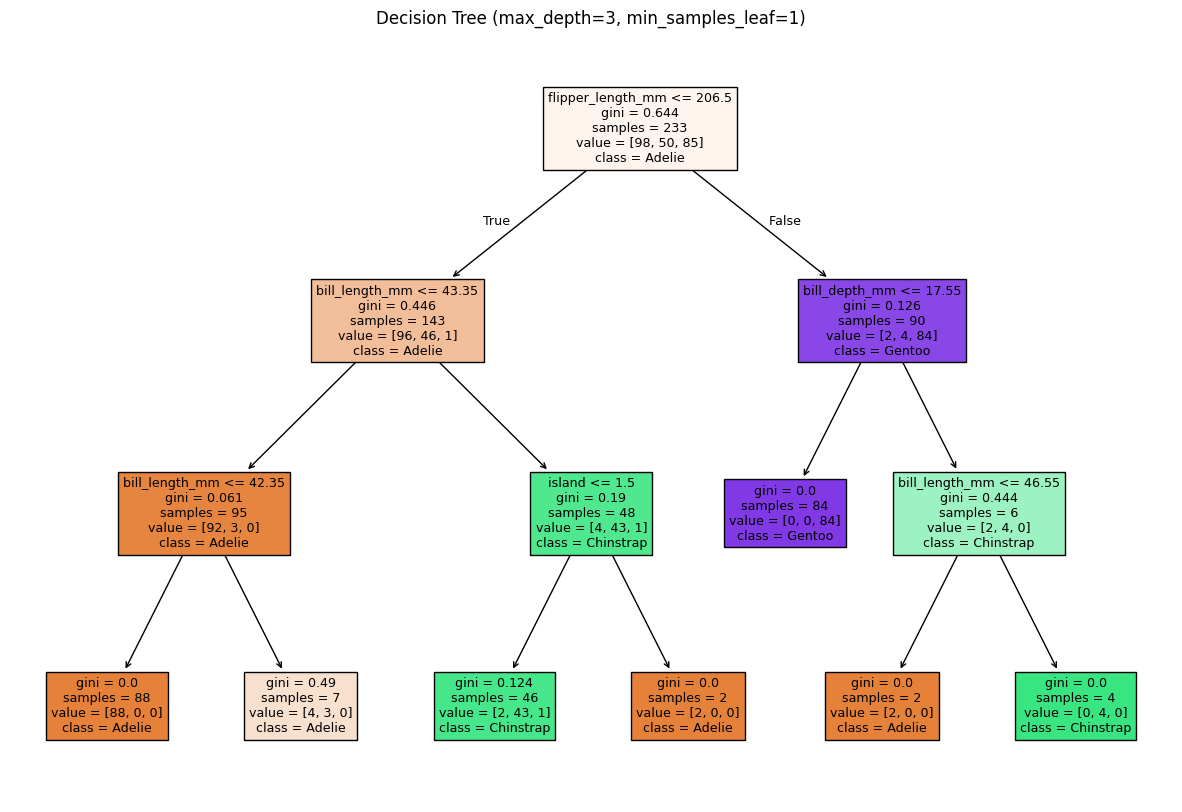

2. Results with maximum depth as 3 and least node size as 3:
training accuracy: 0.96, test accuracy: 0.98


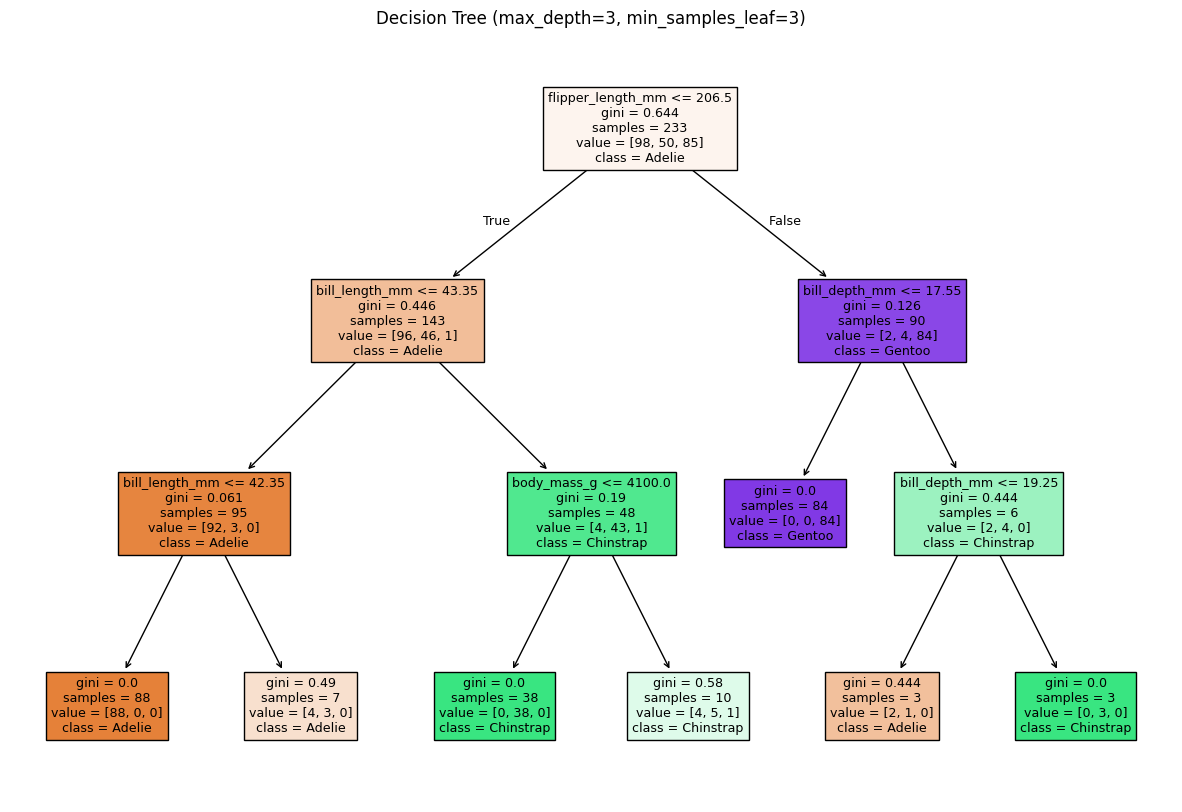

3. Results with maximum depth as 3 and least node size as 5:
training accuracy: 0.96, test accuracy: 0.98


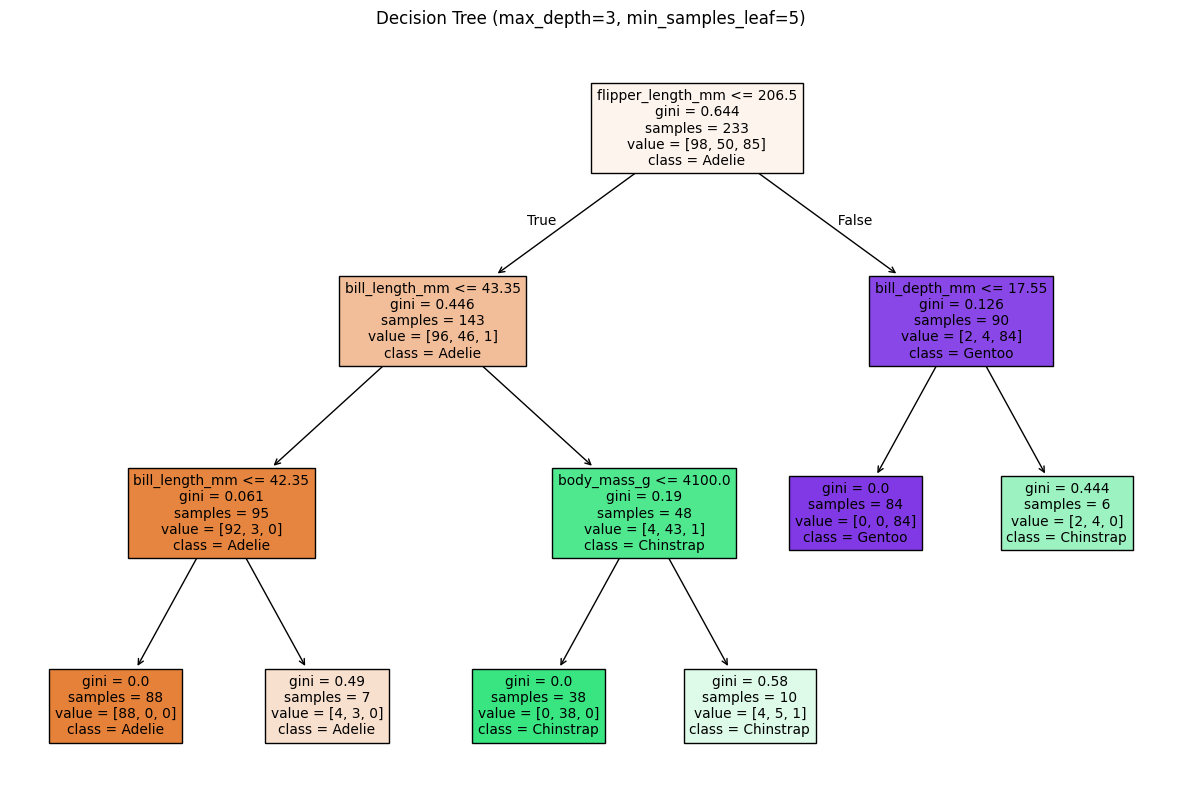

4. Results with maximum depth as 5 and least node size as 1:
training accuracy: 1.00, test accuracy: 0.98


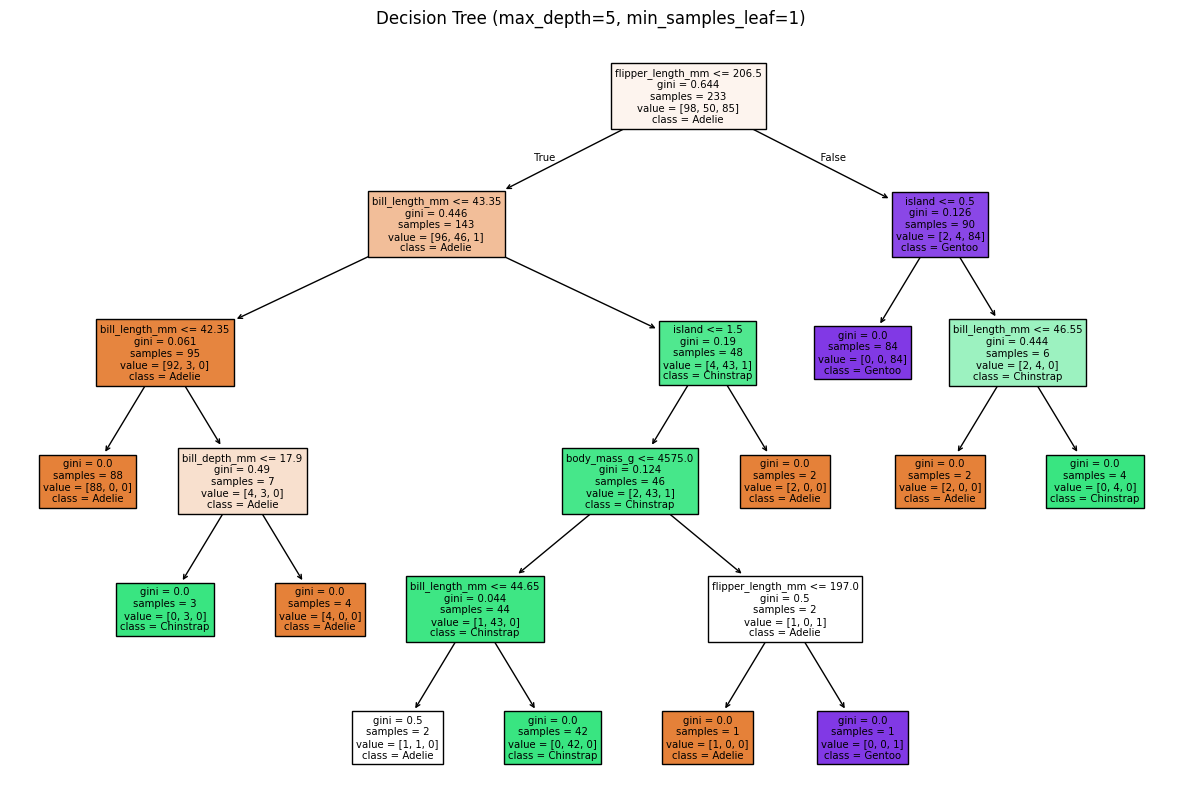

5. Results with maximum depth as 5 and least node size as 3:
training accuracy: 0.99, test accuracy: 0.98


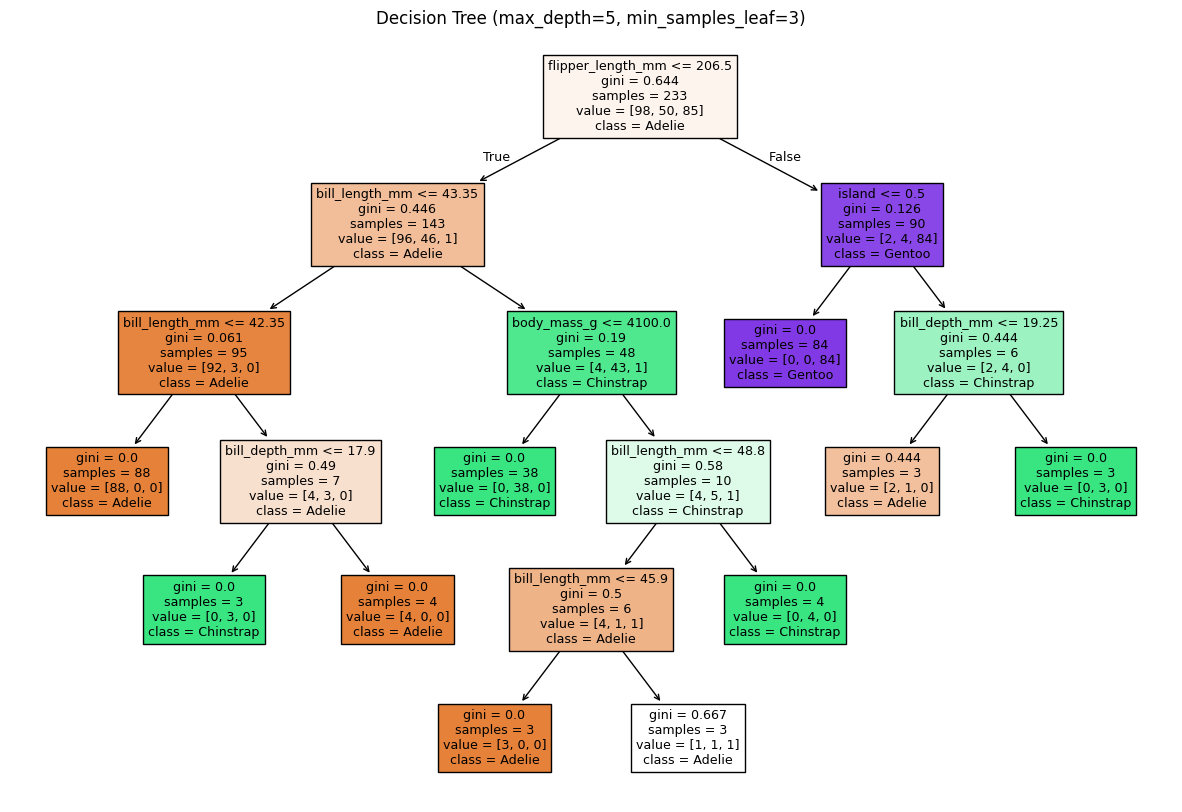

6. Results with maximum depth as 5 and least node size as 5:
training accuracy: 0.97, test accuracy: 0.98


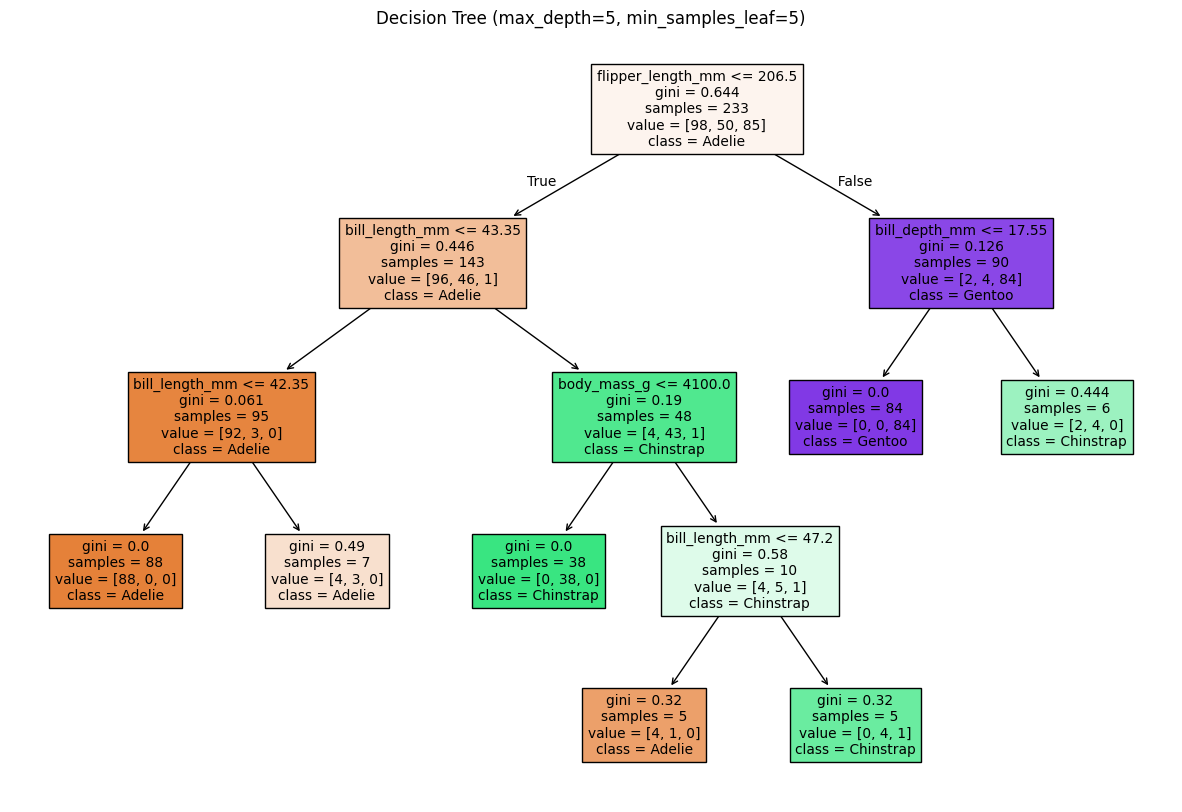

7. Results with maximum depth as 7 and least node size as 1:
training accuracy: 1.00, test accuracy: 0.98


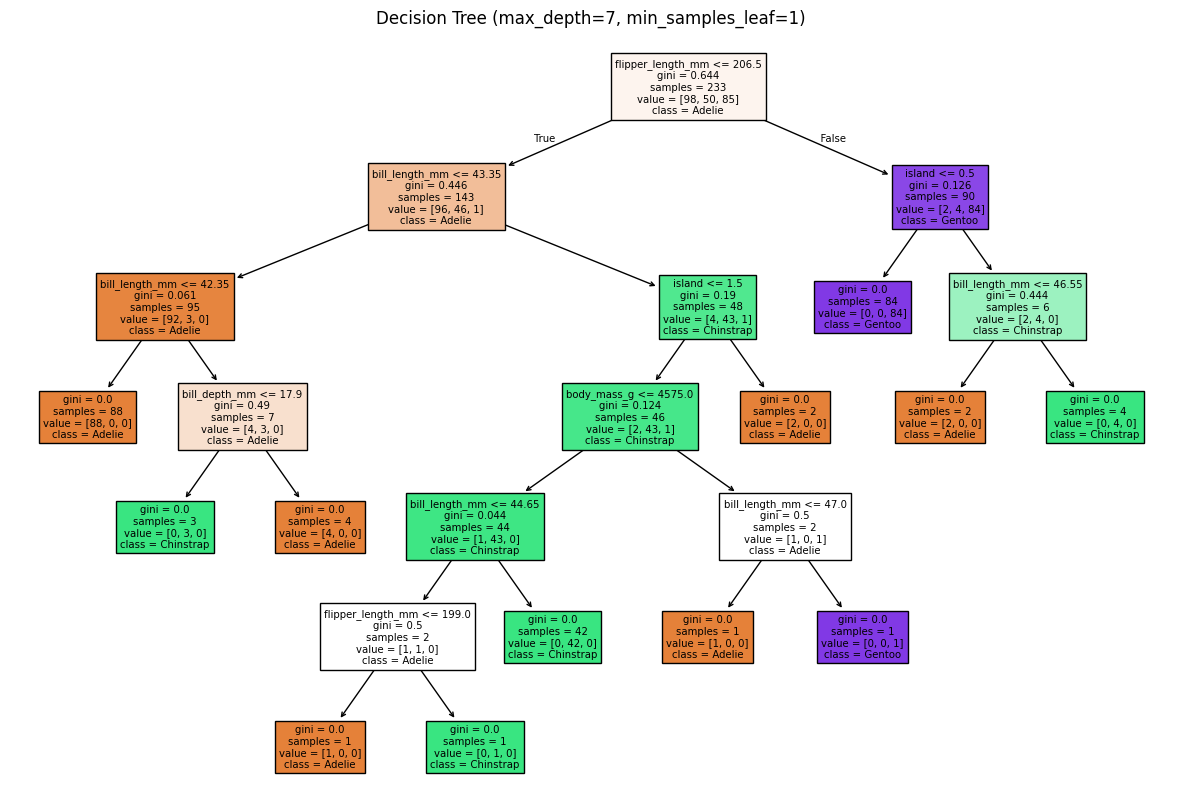

8. Results with maximum depth as 7 and least node size as 3:
training accuracy: 0.99, test accuracy: 0.98


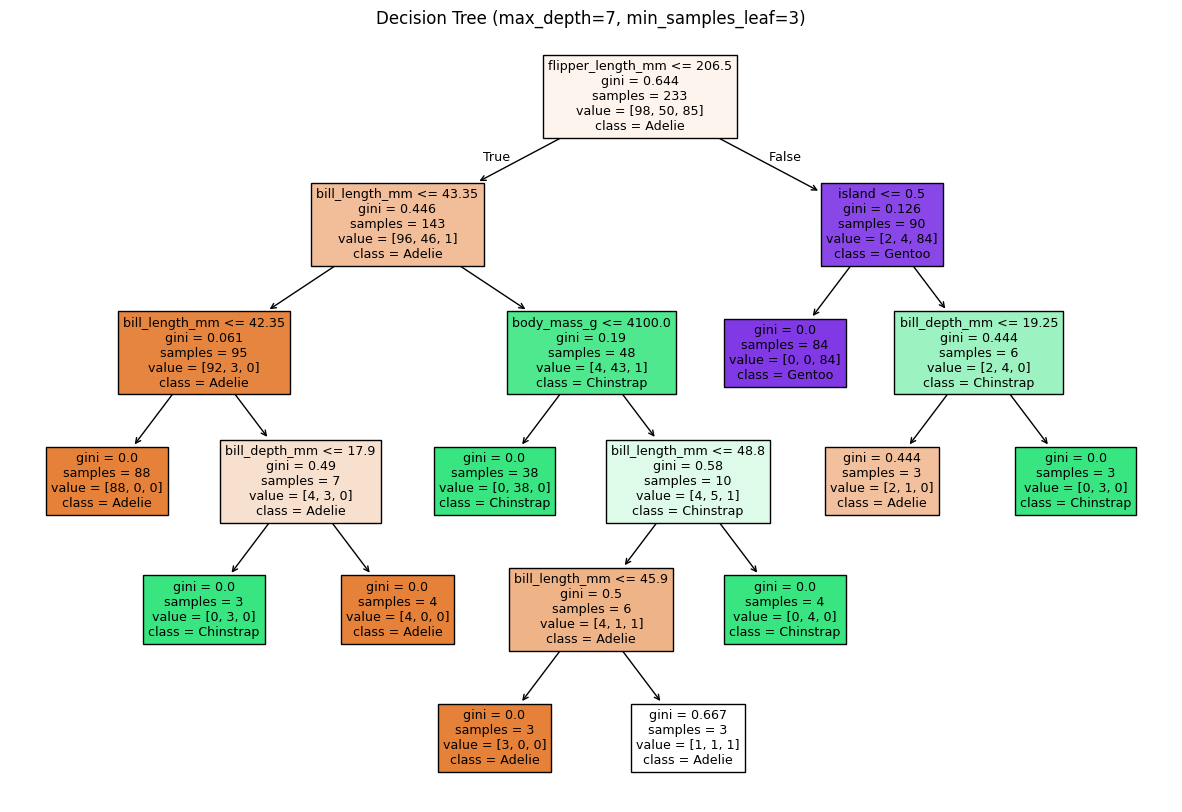

9. Results with maximum depth as 7 and least node size as 5:
training accuracy: 0.97, test accuracy: 0.98


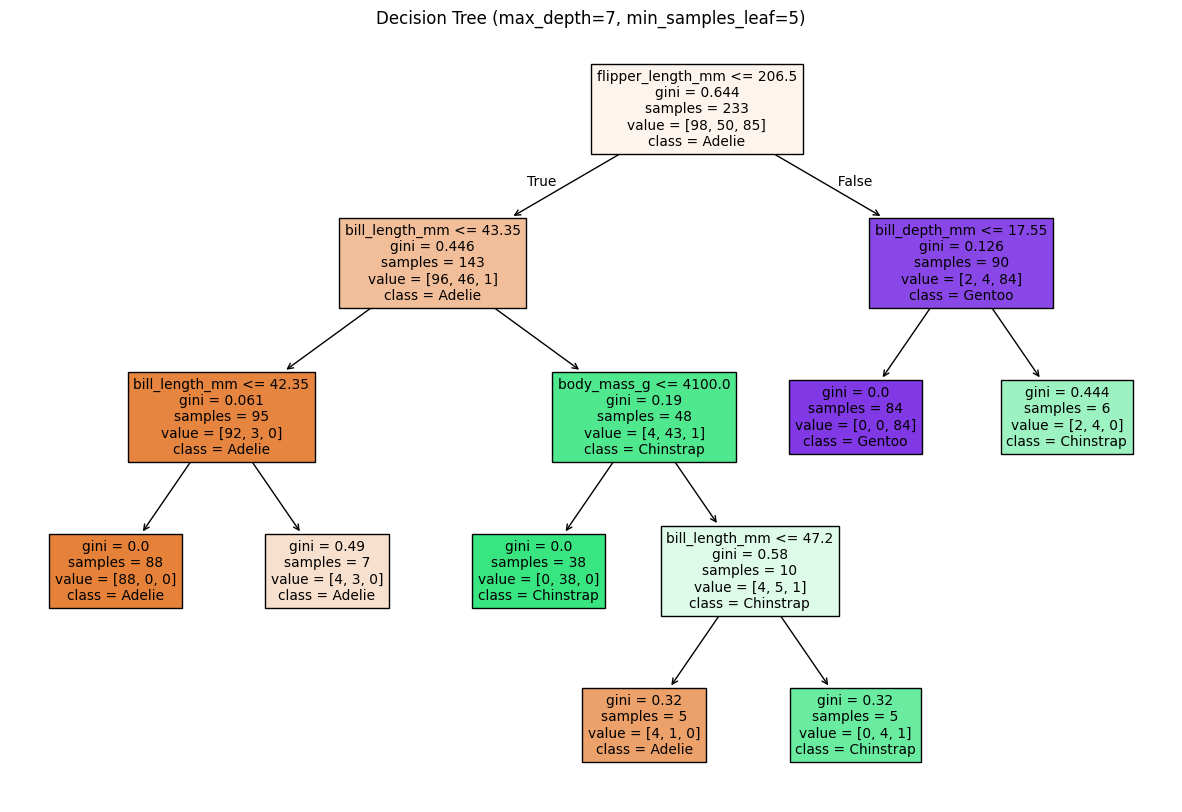

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt

# 定义参数
max_depths = [3, 5, 7]
min_samples_leaf = [1, 3, 5]

print("Q2.1.3 Decision Tree:")
result_counter = 1  # 初始化动态序号

for d in max_depths:
    for n in min_samples_leaf:
        # 训练模型
        clf = DecisionTreeClassifier(max_depth=d, min_samples_leaf=n, random_state=42)
        clf.fit(X_train, y_train)

        # 手动计算准确率
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)
        train_acc = sum(y_train_pred == y_train) / len(y_train)
        test_acc = sum(y_test_pred == y_test) / len(y_test)
        
        # 输出结果
        print(f"{result_counter}. Results with maximum depth as {d} and least node size as {n}:")
        print(f"training accuracy: {train_acc:.2f}, test accuracy: {test_acc:.2f}")
        
        # 绘制并保存决策树
        plt.figure(figsize=(15, 10))
        tree.plot_tree(clf, filled=True, feature_names=X.columns, class_names=[str(c) for c in species_names])
        plt.title(f"Decision Tree (max_depth={d}, min_samples_leaf={n})")
        plt.savefig(f"tree_depth_{d}_leaf_{n}.png")
        plt.show()
        
        # 更新动态序号
        result_counter += 1




## S4

In [4]:
from sklearn.ensemble import BaggingClassifier

# 定义参数
n_estimators = [10, 50, 100]

print("Q2.1.4 Bagging of Trees:")
result_counter = 1  # 初始化动态序号

# 使用已有的基础决策树模型
for d, clf in zip(max_depths, [DecisionTreeClassifier(max_depth=d, random_state=42) for d in max_depths]):
    clf.fit(X_train, y_train)  # 预先训练基础决策树
    for n in n_estimators:
        # 创建 Bagging 分类器，基学习器为已训练的基础决策树
        bagging_clf = BaggingClassifier(estimator=clf, n_estimators=n, random_state=42)
        
        # 训练 Bagging 模型
        bagging_clf.fit(X_train, y_train)
        
        # 手动计算训练集和测试集准确率
        y_train_pred = bagging_clf.predict(X_train)
        y_test_pred = bagging_clf.predict(X_test)
        train_acc = sum(y_train_pred == y_train) / len(y_train)
        test_acc = sum(y_test_pred == y_test) / len(y_test)
        
        # 输出结果
        print(f"{result_counter}. Results with maximum depth as {d} and number of trees as {n}:")
        print(f"training accuracy: {train_acc:.2f}, test accuracy: {test_acc:.2f}")
        
        # 更新动态序号
        result_counter += 1


Q2.1.4 Bagging of Trees:
1. Results with maximum depth as 3 and number of trees as 10:
training accuracy: 0.98, test accuracy: 0.98
2. Results with maximum depth as 3 and number of trees as 50:
training accuracy: 0.98, test accuracy: 0.99
3. Results with maximum depth as 3 and number of trees as 100:
training accuracy: 0.98, test accuracy: 0.98
4. Results with maximum depth as 5 and number of trees as 10:
training accuracy: 1.00, test accuracy: 0.99
5. Results with maximum depth as 5 and number of trees as 50:
training accuracy: 1.00, test accuracy: 0.99
6. Results with maximum depth as 5 and number of trees as 100:
training accuracy: 1.00, test accuracy: 0.99
7. Results with maximum depth as 7 and number of trees as 10:
training accuracy: 1.00, test accuracy: 0.99
8. Results with maximum depth as 7 and number of trees as 50:
training accuracy: 1.00, test accuracy: 0.99
9. Results with maximum depth as 7 and number of trees as 100:
training accuracy: 1.00, test accuracy: 0.99


## S5

In [5]:
from sklearn.ensemble import RandomForestClassifier

# 定义参数
n_estimators = [10, 50, 100]

print("Q2.1.5 Random Forests:")
result_counter = 1  # 初始化动态序号

# 遍历不同的 max_depth 和 n_estimators 组合
for d in max_depths:
    for n in n_estimators:
        # 创建 Random Forest 分类器
        rf_clf = RandomForestClassifier(max_depth=d, n_estimators=n, random_state=42)
        
        # 训练模型
        rf_clf.fit(X_train, y_train)
        
        # 手动计算训练集和测试集准确率
        y_train_pred = rf_clf.predict(X_train)
        y_test_pred = rf_clf.predict(X_test)
        train_acc = sum(y_train_pred == y_train) / len(y_train)
        test_acc = sum(y_test_pred == y_test) / len(y_test)
        
        # 输出结果
        print(f"{result_counter}. Results with maximum depth as {d} and number of trees as {n}:")
        print(f"training accuracy: {train_acc:.2f}, test accuracy: {test_acc:.2f}")
        
        # 更新动态序号
        result_counter += 1


Q2.1.5 Random Forests:
1. Results with maximum depth as 3 and number of trees as 10:
training accuracy: 0.98, test accuracy: 0.98
2. Results with maximum depth as 3 and number of trees as 50:
training accuracy: 0.98, test accuracy: 0.98
3. Results with maximum depth as 3 and number of trees as 100:
training accuracy: 0.97, test accuracy: 0.98
4. Results with maximum depth as 5 and number of trees as 10:
training accuracy: 1.00, test accuracy: 0.99
5. Results with maximum depth as 5 and number of trees as 50:
training accuracy: 1.00, test accuracy: 0.99
6. Results with maximum depth as 5 and number of trees as 100:
training accuracy: 1.00, test accuracy: 0.99
7. Results with maximum depth as 7 and number of trees as 10:
training accuracy: 1.00, test accuracy: 0.99
8. Results with maximum depth as 7 and number of trees as 50:
training accuracy: 1.00, test accuracy: 0.99
9. Results with maximum depth as 7 and number of trees as 100:
training accuracy: 1.00, test accuracy: 0.99


## S6

Q2.1.6 Relationship of Bias/Variance with respect to Number of Trees in Random Forests:
bias^2 - trees:


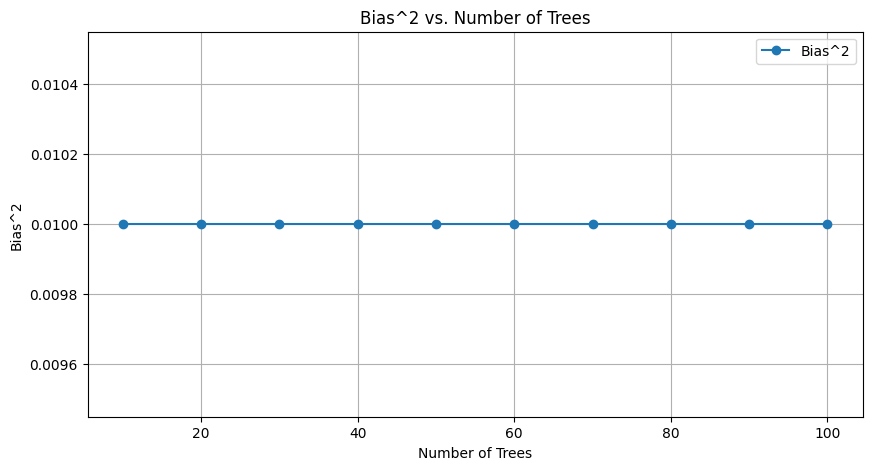

In [ ]:
from mlxtend.evaluate import bias_variance_decomp
import numpy as np
import matplotlib.pyplot as plt

# 定义树的数量范围
num_trees = list(range(10, 110, 10))

# 保存结果
bias2_values = []
variance_values = []

# 定义随机森林的基础配置
max_depth = 5  # 固定 max_depth 为一个适中的值
random_state = 42  # 保证结果可重复

# 遍历不同的树数量
for n in num_trees:
    rf_clf = RandomForestClassifier(n_estimators=n, max_depth=max_depth, random_state=random_state)
    
    # 计算偏差、方差、均方误差
    avg_expected_loss, avg_bias_squared, avg_variance = bias_variance_decomp(
        rf_clf, X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy(),
        loss='0-1_loss', random_seed=random_state
    )
    
    # 保存结果
    bias2_values.append(avg_bias_squared)
    variance_values.append(avg_variance)

print('Q2.1.6 Relationship of Bias/Variance with respect to Number of Trees in Random Forests:')
print('bias^2 - trees:')

# 绘制偏差平方与树数量的关系曲线
plt.figure(figsize=(10, 5))
plt.plot(num_trees, bias2_values, marker='o', label='Bias^2')
plt.title("Bias^2 vs. Number of Trees")
plt.xlabel("Number of Trees")
plt.ylabel("Bias^2")
plt.legend()
plt.grid()
plt.savefig("bias2_vs_trees.png")
plt.show()



The bias^2 remains constant as the number of trees increase. It can be due to the fact that the model has reached the optimal bias^2, adding more trees cannot significantly reduce the bias^2 of the model. It can also be due to the fact that there is unavoidable noise or nonlinear structure in the data features, and even an ideal model cannot further reduce the bias. 
Note that the bias is inherent to the model, so such situation can also happen since the total model complexity doesn't change as the number of tree increase, which is because each tree in random forests is independent.

variance - trees:


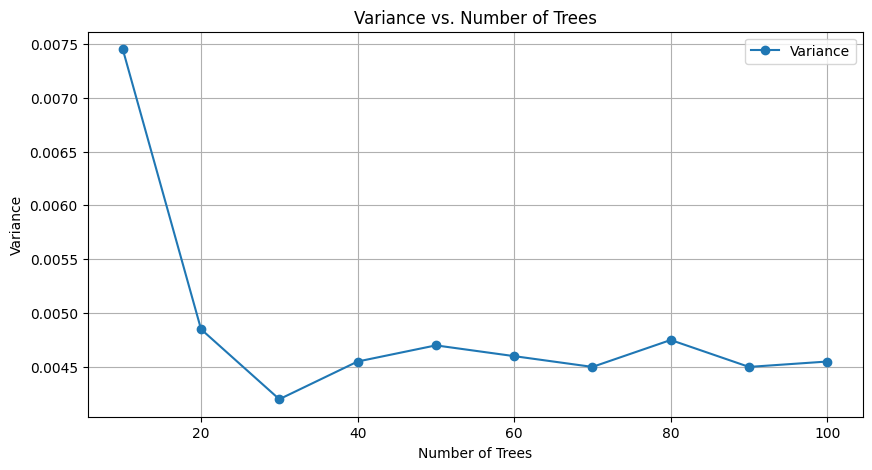

In [12]:
print('variance - trees:')

# 绘制方差与树数量的关系曲线
plt.figure(figsize=(10, 5))
plt.plot(num_trees, variance_values, marker='o', label='Variance')
plt.title("Variance vs. Number of Trees")
plt.xlabel("Number of Trees")
plt.ylabel("Variance")
plt.legend()
plt.grid()
# plt.savefig("variance_vs_trees.png")
plt.show()

Variance captures how much the classifier changes if the model is trained on a different training set.
The variance decreases significantly at first and then stays stable after around 30 trees.
Variance decreases significantly as the number of trees increases due to the averaging effect of ensemble learning. However, as the number of trees increases, the reduction slows and eventually stabilizes. This is due to the additional trees contribute less unique information, and the model converges as the predictions become more consistent.

## Performance Evaluation

In [ ]:
from os import path as osp
import numpy as np

# load data
def load_data():

    data_dir = './data'
    train_val_data_path = osp.join(data_dir, 'train_validation_data.npy')
    train_val_label_path = osp.join(data_dir, 'train_validation_label.npy')
    test_data_path = osp.join(data_dir, 'test_data.npy')
    test_label_path = osp.join(data_dir, 'test_label.npy')

    train_val_data = np.load(train_val_data_path)
    train_val_label = np.load(train_val_label_path)
    test_data = np.load(test_data_path)
    test_label = np.load(test_label_path)
    return train_val_data, train_val_label, test_data, test_label


train_validation_data, train_validation_label, test_data, test_label = load_data()

print(f'# ========== data info ============ #')
print(f'train validation data: {train_validation_data.shape}')
print(f'train validation label: {train_validation_label.shape}')
print(f'test data: {test_data.shape}')
print(f'test label: {test_label.shape}')
print(f'# ================================= #')

In [ ]:
# data split for K-fold Cross-validation

def train_validation_split(K, train_val_data, train_val_label):
    """
    Split train-validation data into K folds with balanced classes (0 and 1).
    """
    # Separate data by class
    class_0_indices = np.where(train_val_label == 0)[0]
    class_1_indices = np.where(train_val_label == 1)[0]
    np.random.seed(42)  # 固定随机数种子从而复现结果
    np.random.shuffle(class_0_indices)
    np.random.shuffle(class_1_indices)

    # Split indices into K folds
    class_0_folds = np.array_split(class_0_indices, K)
    class_1_folds = np.array_split(class_1_indices, K)

    train_datas, train_labels, val_datas, val_labels = [], [], [], []

    for i in range(K):
        # Validation set
        val_indices = np.concatenate([class_0_folds[i], class_1_folds[i]])
        val_data = train_val_data[val_indices]
        val_label = train_val_label[val_indices]

        # Training set
        train_indices = np.concatenate([np.concatenate(class_0_folds[:i] + class_0_folds[i+1:]),
                                         np.concatenate(class_1_folds[:i] + class_1_folds[i+1:])])
        train_data = train_val_data[train_indices]
        train_label = train_val_label[train_indices]

        # Append to list
        train_datas.append(train_data)
        train_labels.append(train_label)
        val_datas.append(val_data)
        val_labels.append(val_label)

    return train_datas, train_labels, val_datas, val_labels

In [ ]:
# evaluation metrics

def eva_precision(true_label, pred_label, _class):
    
    """
    Compute precision for _class.
    """
    tp = np.sum((pred_label == _class) & (true_label == _class))
    fp = np.sum((pred_label == _class) & (true_label != _class))
    precison = tp / (tp + fp) if (tp + fp) > 0 else 0.0

    return precison

def eva_recall(true_label, pred_label, _class):
    """
    Compute recall for _class.
    """
    tp = np.sum((pred_label == _class) & (true_label == _class))
    fn = np.sum((pred_label != _class) & (true_label == _class))
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    return recall

def eva_f1(true_label, pred_label, _class):
    """
    Compute F1-score for _class.
    """
    precision = eva_precision(true_label, pred_label, _class)
    recall = eva_recall(true_label, pred_label, _class)
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    return f1

def eva_accuracy(true_label, pred_label):
    """
    Compute accuracy for all classes.
    """
    correct = np.sum(true_label == pred_label)
    accuracy = correct / len(true_label)

    return accuracy

def eva_auroc(true_label, pred_label):
    """
    计算 AUROC (Area Under the Receiver Operating Characteristic Curve) 的函数。
    
    :param true_label: 样本的真实标签，0为负类，1为正类 (numpy array)
    :param pred_label: 模型预测值 (numpy array)
    :return: auroc (float)
    """
    # 将正类和负类样本分开
    pos_scores = pred_label[true_label == 1]
    neg_scores = pred_label[true_label == 0]
    
    # 样本数量
    m_pos = len(pos_scores)
    m_neg = len(neg_scores)
    
    # 初始化累计值
    auc_sum = 0
    
    # 遍历所有正负样本对
    for pos_score in pos_scores:
        for neg_score in neg_scores:
            e_ij = pos_score - neg_score  # 计算差值
            # 计算 u(e_ij) 的值
            if e_ij > 0:
                auc_sum += 1
            elif e_ij == 0:
                auc_sum += 0.5
            elif e_ij < 0:  # 如果 e_ij < 0，不增加 auc_sum
                auc_sum += 0

    # 计算 AUROC
    auroc = auc_sum / (m_pos * m_neg)
    return auroc

def evaluation(true_label, pred_label, _class):

    precision = eva_precision(true_label, pred_label, _class)
    recall = eva_recall(true_label, pred_label, _class)
    f1 = eva_f1(true_label, pred_label, _class)
    accuracy = eva_accuracy(true_label, pred_label)
    auroc = eva_auroc(true_label, pred_label)

    return {'precision': precision, 'recall': recall, 'f1': f1, 'accuracy': accuracy, 'auroc': auroc}
    


In [ ]:
# model training and hyper-parameters fine-tuning
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

K = 5

# hyper-parameter for logistic regression
hyper_parameters_logistic_regression = {

    # TODO: please choose different values to tune the model
    'penalty': 'l2', # ['l1', 'l2']
}

# # hyper-parameter for SVM
# hyper_parameters_svm = {

#     # TODO: please choose different values to tune the model
#     'C': 1e-3, # [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

# }

# obtain cross-validation set
train_datas, train_labels, validation_datas, validation_labels = train_validation_split(K, train_validation_data, train_validation_label)


for i, (train_data, train_label, validation_data, validation_label) in enumerate(zip(train_datas, train_labels, validation_datas, validation_labels)):

    print(f'# ======================= {i + 1}-th time validation ======================= #')

    # logistic regression

    print(f'Algorithm: [logistic regression] =========================')
    print(f'hyper-parameter: {hyper_parameters_logistic_regression}')
    lr_model = LogisticRegression(solver='liblinear', **hyper_parameters_logistic_regression).fit(train_data, train_label)

    # performance evaluation on validation set for tuning hyper-parameters
    pred_label = lr_model.predict(validation_data)
    F1_0 = eva_f1(validation_label, pred_label, _class=0)
    print(f'F1 (Val set of Class-0): {F1_0:.4f}')
    F1_1 = eva_f1(validation_label, pred_label, _class=1)
    print(f'F1 (Val set of Class-1): {F1_1:.4f}')

    # # SVM

    # print(f'Algorithm: [SVM] =========================================')
    # print(f'hyper-parameter: {hyper_parameters_svm}')
    # svm_model = SVC(kernel='linear', **hyper_parameters_svm).fit(train_data, train_label)

    # # performance evaluation on validation set for tuning hyper-parameters
    # pred_label = svm_model.predict(validation_data)
    # F1_0 = eva_f1(validation_label, pred_label, _class=0)
    # print(f'F1 (Val set of Class-0): {F1_0:.4f}')
    # F1_1 = eva_f1(validation_label, pred_label, _class=1)
    # print(f'F1 (Val set of Class-1): {F1_1:.4f}')


In [ ]:
# performance evaluation on test set

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

K = 5

# hyper-parameter penlty for logistic regression. Hint: len(penalty) = 5
penalty = [
    'l1','l2','l1','l1','l1'
    # TODO: the optimal parameter selection for each split
]


# # hyper-parameter C for SVM. Hint: len(C) = 5
# C = [
#     1e-5, 1e-3, 1e-4, 1e-5, 1e-3
#     # TODO: the optimal parameter selection for each split

# ]

    
# obtain training data
train_datas, train_labels, _, _ = train_validation_split(K, train_validation_data, train_validation_label)


for i, (train_data, train_label) in enumerate(zip(train_datas, train_labels)):

    print(f'# ======================= {i + 1}-th time validation ======================= #')

    # logistic regression

    print(f'Algorithm: [logistic regression] =========================')
    print(f'hyper-parameter: {hyper_parameters_logistic_regression}')
    lr_model = LogisticRegression(solver='liblinear', penalty=penalty[i]).fit(train_data, train_label)


    # performance evaluation on test set
    pred_label = lr_model.predict(test_data)
    results_0 = evaluation(test_label, pred_label, _class=0)
    results_1 = evaluation(test_label, pred_label, _class=1)
    print(f'Result Class 0 (Test set): {results_0}')
    print(f'Result Class 1 (Test set): {results_1}')

    # # SVM

    # print(f'Algorithm: [SVM] =========================================')
    # print(f'hyper-parameter: {hyper_parameters_svm}')
    # svm_model = SVC(kernel='linear', C=C[i]).fit(train_data, train_label)

    # # performance evaluation on test set
    # pred_label = svm_model.predict(test_data)
    # results_0 = evaluation(test_label, pred_label, _class=0)
    # results_1 = evaluation(test_label, pred_label, _class=1)
    # print(f'Result Class 0 (Test set): {results_0}')
    # print(f'Result Class 1 (Test set): {results_1}')